In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,mean, count
from pyspark.sql.types import *

In [37]:
data_path = "./data/"
review_file_mapping = {"giftcards":"amazon_reviews_us_Gift_Card_v1_00.tsv"}

spark = SparkSession.builder \
    .appName("Analyse Reviews") \
    .getOrCreate()

In [38]:
schema = StructType([
    StructField("marketplace", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", IntegerType(), True),
    StructField("helpful_votes", IntegerType(), True),
    StructField("total_votes", IntegerType(), True),
    StructField("vine", BooleanType(), True),
    StructField("verified_purchase", BooleanType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", StringType(), True)
])

file_path = data_path + review_file_mapping["giftcards"]
df = spark.read.csv(file_path, schema=schema, sep="\t", header=True)

In [39]:
df.describe().show()

+-------+-----------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+--------------------+--------------------+-----------+
|summary|marketplace|         customer_id|     review_id|product_id|      product_parent|       product_title|product_category|       star_rating|      helpful_votes|       total_votes|     review_headline|         review_body|review_date|
+-------+-----------+--------------------+--------------+----------+--------------------+--------------------+----------------+------------------+-------------------+------------------+--------------------+--------------------+-----------+
|  count|     149086|              149086|        149086|    149086|              149086|              149086|          149086|            149086|             149086|            149086|              149086|              149080|     149081|
|   mean|       NULL| 2.628253678963149E

In [40]:
avg_star_rating = df.select(mean(col("star_rating"))).show()

reviews_per_category = df.groupBy("product_category").count().show()

avg_helpful_votes_per_rating = df.groupBy("star_rating").agg(mean(col("helpful_votes"))).show()

+-----------------+
| avg(star_rating)|
+-----------------+
|4.731363105858364|
+-----------------+

+----------------+------+
|product_category| count|
+----------------+------+
|       Gift Card|149086|
+----------------+------+

+-----------+-------------------+
|star_rating| avg(helpful_votes)|
+-----------+-------------------+
|          1|  6.341331107865638|
|          3| 1.0788973384030418|
|          5|0.11094064405708162|
|          4|  0.412922203063191|
|          2|  4.377310388782664|
+-----------+-------------------+



<Figure size 1200x600 with 0 Axes>

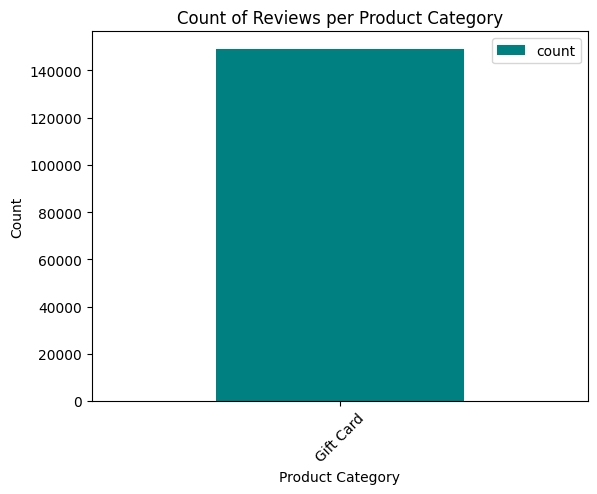

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

pdf_reviews_per_category = df.groupBy("product_category").count().toPandas()

plt.figure(figsize=(12, 6))
pdf_reviews_per_category.plot(kind='bar', x='product_category', y='count', color='teal')
plt.title('Count of Reviews per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

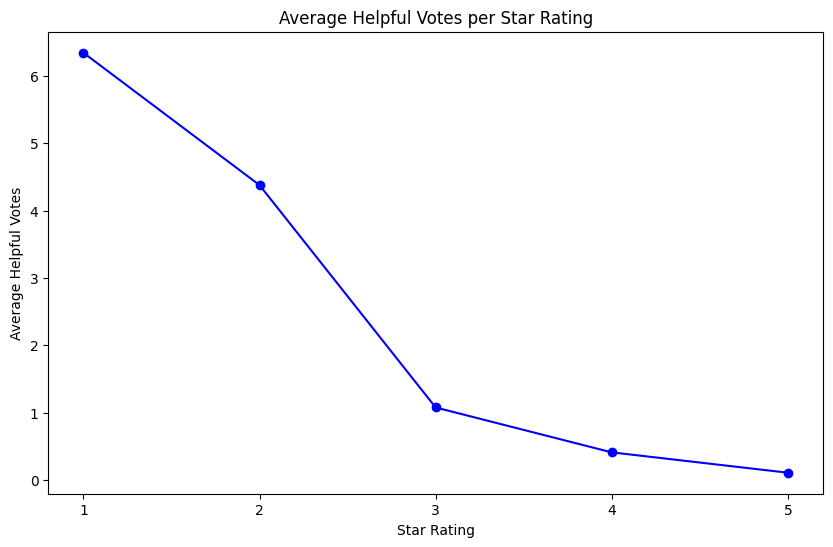

In [54]:
pdf_avg_helpful_votes_per_rating = df.groupBy("star_rating")\
                                     .agg(mean(col("helpful_votes")))\
                                     .orderBy("star_rating")\
                                     .toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pdf_avg_helpful_votes_per_rating['star_rating'], pdf_avg_helpful_votes_per_rating['avg(helpful_votes)'], marker='o', color='blue')
plt.title('Average Helpful Votes per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')
plt.xticks(range(1, 6))
plt.show()

In [47]:
from pyspark.sql.functions import sum as _sum

df_with_helpful_flag = df.withColumn("is_helpful", (col("helpful_votes") > 0).cast("integer"))

helpful_percentage_per_rating = df_with_helpful_flag.groupBy("star_rating").agg(
    (_sum("is_helpful") / count("*") * 100).alias("helpful_percentage")
).orderBy("star_rating")

helpful_percentage_per_rating.show()

+-----------+------------------+
|star_rating|helpful_percentage|
+-----------+------------------+
|          1|30.940955560191945|
|          2|  24.8565965583174|
|          3| 12.70595690747782|
|          4|5.9235216553402985|
|          5| 2.102398445751644|
+-----------+------------------+



<Figure size 1000x600 with 0 Axes>

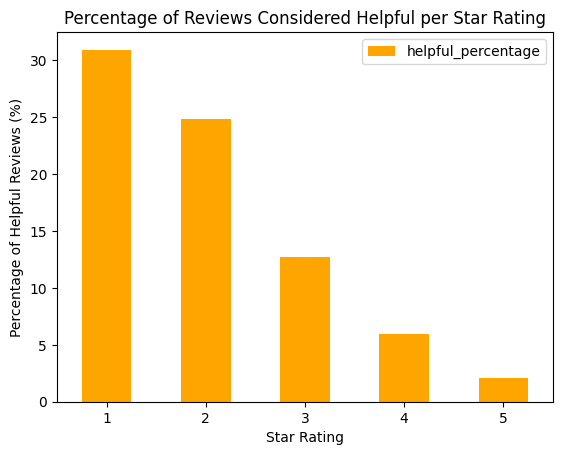

In [52]:
pdf_helpful_percentage = helpful_percentage_per_rating.toPandas()

plt.figure(figsize=(10, 6))
pdf_helpful_percentage.plot(kind='bar', x='star_rating', y='helpful_percentage', color='orange')
plt.title('Percentage of Reviews Considered Helpful per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Percentage of Helpful Reviews (%)')
plt.xticks(rotation=0)
plt.show()